# 01-Data_Exploration

In [10]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [11]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

In [12]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

In [13]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [14]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [15]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:07<00:21,  7.19s/it]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:15<00:15,  7.60s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:20<00:06,  6.70s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:28<00:00,  7.15s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [18]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:03<00:09,  3.21s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:07<00:07,  3.58s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:11<00:04,  4.17s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)
Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [19]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [20]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [21]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:08<00:00,  8.26s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:08<00:00,  8.26s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [22]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [23]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [26]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [27]:
# Model Poisoning Attack
print("--- Applying Model Poisoning ---")
num_malicious_clients = 11  # about 33% of 33 clients
malicious_client_ids = list(range(num_malicious_clients))
target_class = 6 # 'DDOS-ICMP_FLOOD' - This is the most frequent class
new_class = 0    # 'BENIGN'
poison_fraction = 1.0 # poison 100% of the target class samples in malicious clients

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Flipping label from {target_class} to {new_class} for {poison_fraction*100}% of samples of malicious clients.")

for client_id in malicious_client_ids:
    # fl_y_train[client_id] is a pandas Series.
    # We can get the indices of the target class and replace the labels.
    y_train_series = fl_y_train[client_id]
    target_indices = y_train_series[y_train_series == target_class].index

    num_to_poison = int(len(target_indices) * poison_fraction)

    # Randomly select indices to poison
    poison_indices = np.random.choice(target_indices, num_to_poison, replace=False)

    # Flip the labels in the pandas Series
    fl_y_train[client_id].loc[poison_indices] = new_class

    print(f"Client {client_id}: Flipped {len(poison_indices)} labels from class {target_class} to {new_class}.")

print("--- Model Poisoning Applied ---")


--- Applying Model Poisoning ---
Poisoning 11 clients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Flipping label from 6 to 0 for 100.0% of samples of malicious clients.
Client 0: Flipped 12985 labels from class 6 to 0.
Client 1: Flipped 12985 labels from class 6 to 0.
Client 2: Flipped 12985 labels from class 6 to 0.
Client 3: Flipped 12986 labels from class 6 to 0.
Client 4: Flipped 12986 labels from class 6 to 0.
Client 5: Flipped 0 labels from class 6 to 0.
Client 6: Flipped 12986 labels from class 6 to 0.
Client 7: Flipped 12986 labels from class 6 to 0.
Client 8: Flipped 12986 labels from class 6 to 0.
Client 9: Flipped 12986 labels from class 6 to 0.
Client 10: Flipped 12986 labels from class 6 to 0.
--- Model Poisoning Applied ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
0     14977
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  0 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8 33 26 22 12 21  9
 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
0     14977
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       

Visualize Data Distribution

STRATIFIED Client

In [29]:
#STRATIFIED Client

In [30]:
#LEAVE_ONE_OUT

In [31]:
#Half begign

In [32]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


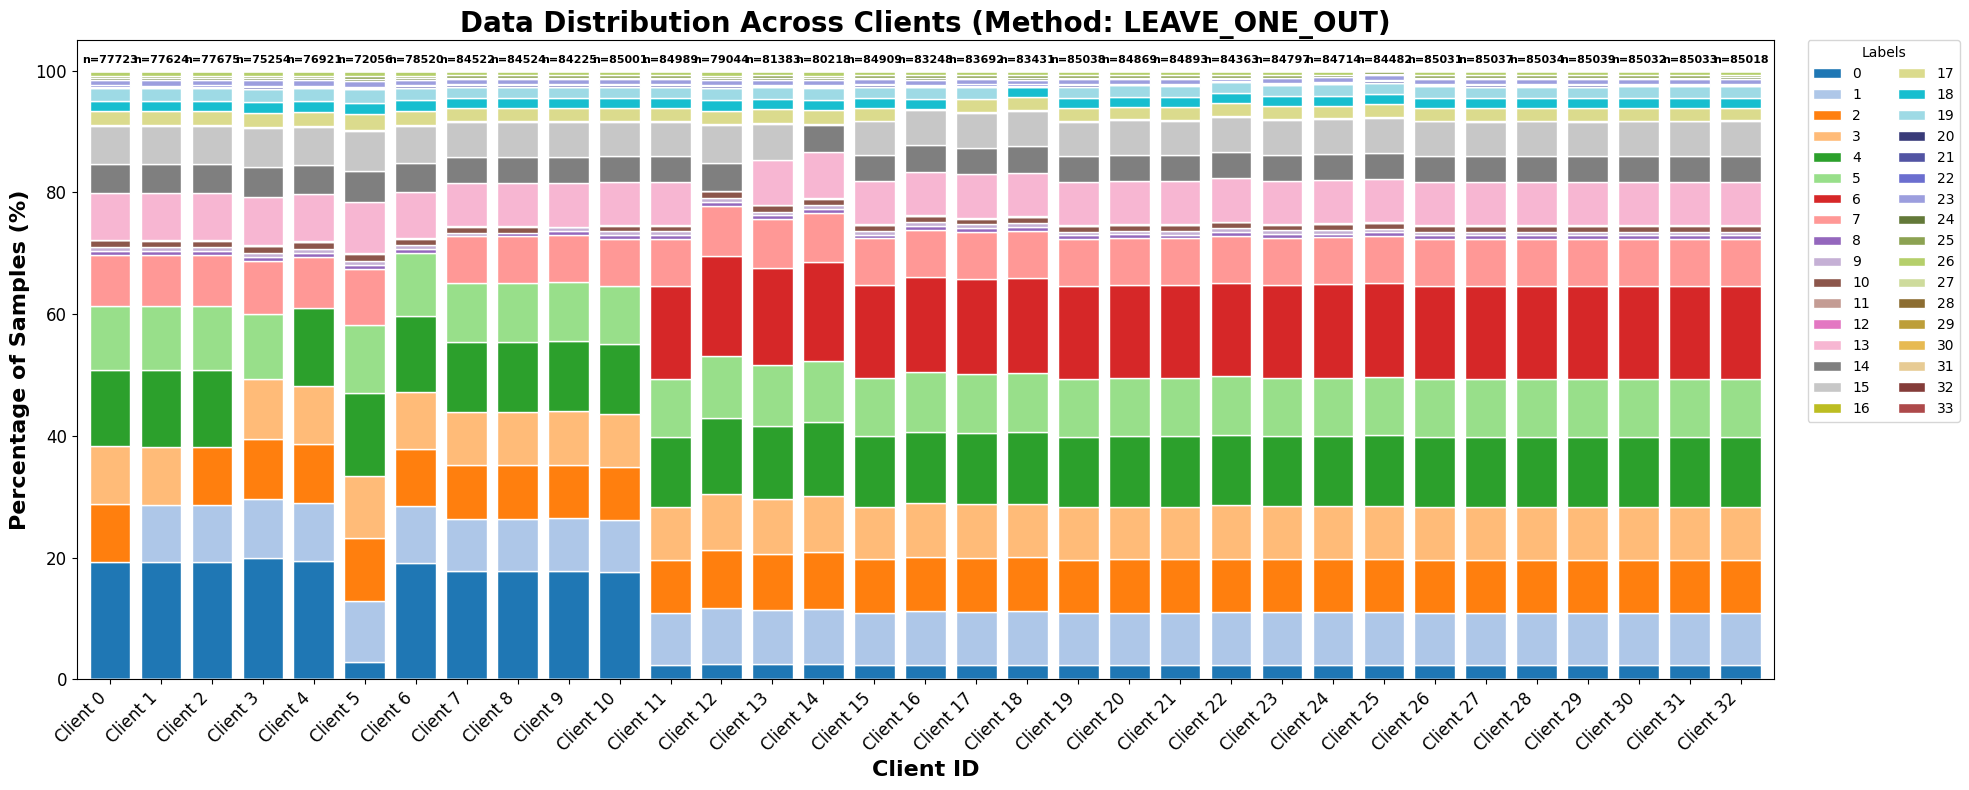

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [33]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [34]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [35]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [36]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [37]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [38]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [39]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [40]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=1, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        return self.model.get_weights(), len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [41]:
from flwr.server.strategy import FedAdagrad

from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10, #10,
#         min_evaluate_clients=5, #5,
#         min_available_clients=10, #10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         #evaluate_metrics_aggregation_fn=weighted_average,
# )

# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

strategy = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_OF_CLIENTS,
        initial_parameters=initial_parameters,
        evaluate_fn=get_evaluate_fn(server_model),
    )

# Define FedProx strategy
# strategy = FedProx(
#     proximal_mu=1.0,  # Proximal term coefficient (tune as needed)
#     fraction_fit=1.0,  # Fraction of clients to sample for training
#     fraction_evaluate=1.0,  # Fraction of clients to sample for evaluation
#     min_fit_clients=NUM_OF_CLIENTS,  # Minimum number of clients for training
#     min_evaluate_clients=NUM_OF_CLIENTS,  # Minimum number of clients for evaluation
#     min_available_clients=NUM_OF_CLIENTS,  # Minimum number of available clients
#     evaluate_fn=get_evaluate_fn(server_model),
# )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-09-04 16:15:00,899	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3993064243.0, 'memory': 7986128487.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


Server Evaluating... Evaluation Count: 0
 1022/23275 ━━━━━━━━━━━━━━━━━━━━ 1:07 3ms/step - accuracy: 0.0019 - loss: 3.6502

(pid=6225) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=6225) E0000 00:00:1757002511.003091    6225 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6225) E0000 00:00:1757002511.030443    6225 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=6225) W0000 00:00:1757002511.163829    6225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=6225) W0000 00:00:1757002511.163896    6225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=6225) W0000 00:00:1757002511.163903    6225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking t

23275/23275 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.0019 - loss: 3.6452
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Prediction:  [[0.04070683 0.02150005 0.03064459 ... 0.01944822 0.02834316 0.02290444]
 [0.02197025 0.02480991 0.0149099  ... 0.01346001 0.02034012 0.02217118]
 [0.03351382 0.03124568 0.02655275 ... 0.02875498 0.02864036 0.02423963]
 ...
 [0.01906937 0.01898556 0.02284271 ... 0.01363313 0.03210904 0.02045646]
 [0.03041159 0.02676973 0.02400562 ... 0.02234834 0.03018516 0.02655676]
 [0.03238909 0.0263693  0.02322994 ... 0.02459671 0.03026486 0.02761431]] (744790, 34)


INFO :      initial parameters (loss, other metrics): 3.6458847522735596, {'accuracy': 0.001906577730551362}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.0019, Loss: 3.6459


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(pid=6226) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=6226) E0000 0

(ClientAppActor pid=6226) Client ID: 17


(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=6225) 
(ClientAppActor pid=6225)         


(ClientAppActor pid=6226) Client  17 Training...
  11/2616 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.0123 - loss: 3.5921       
   1/2602 ━━━━━━━━━━━━━━━━━━━━ 1:34:53 2s/step - accuracy: 0.0000e+00 - loss: 3.6367
  37/2616 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.0878 - loss: 3.4362
  26/2602 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0395 - loss: 3.4827
  64/2616 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1592 - loss: 3.2928
  78/2602 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1607 - loss: 3.2091
 358/2616 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4660 - loss: 2.0732
 446/2616 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5008 - loss: 1.8958
 485/2616 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5133 - loss: 1.8314
(ClientAppActor pid=6225) Client ID: 16
(ClientAppActor pid=6225) Client  16 Training...
 159/2602 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2852 - loss: 2.7525  [repeated 8x across cluster]
1338/2616 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

(ClientAppActor pid=6225) 
(ClientAppActor pid=6225)         
(ClientAppActor pid=6225) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=6225)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=6225)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=6225) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=6225)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=6225) Client ID: 12
(ClientAppActor pid=6225) Client  12 Training...


(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)         


  13/2471 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0122 - loss: 3.5018       
2602/2616 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6729 - loss: 0.9492 [repeated 15x across cluster]
2616/2616 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6732 - loss: 0.9474 [repeated 3x across cluster]
(ClientAppActor pid=6226) Client  17 Training complete...
  39/2471 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0837 - loss: 3.3707 
(ClientAppActor pid=6226) Client ID: 25
(ClientAppActor pid=6226) Client  25 Training...
 437/2471 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5106 - loss: 1.8508
  18/2641 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0240 - loss: 3.5570        
1439/2471 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6516 - loss: 1.1219 [repeated 87x across cluster]
1297/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6207 - loss: 1.2052 [repeated 6x across cluster]
(ClientAppActor pid=6225) Client  12 Training complete...


(ClientAppActor pid=6225) 
(ClientAppActor pid=6225)         
(ClientAppActor pid=6225) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=6225)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=6225)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=6225) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=6225)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=6225) Client ID: 23
(ClientAppActor pid=6225) Client  23 Training...
2591/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6669 - loss: 0.9394 [repeated 83x across cluster]
2342/2641 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6614 - loss: 0.9717 [repeated 4x across cluster]


(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)         


  10/2650 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.0111 - loss: 3.5418       
  31/2650 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.0567 - loss: 3.4297
  46/2650 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1012 - loss: 3.3497
  58/2650 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1298 - loss: 3.2839
  76/2650 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1679 - loss: 3.1802
  95/2650 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2048 - loss: 3.0671
 108/2650 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.2269 - loss: 2.9897
 119/2650 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2440 - loss: 2.9265
 132/2650 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2626 - loss: 2.8532
 151/2650 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2876 - loss: 2.7508
 176/2650 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3163 - loss: 2.6274
 195/2650 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3356 - loss: 2.5422
 214/2650 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  55/2544 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - accuracy: 0.1247 - loss: 3.3200
  59/2544 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - accuracy: 0.1341 - loss: 3.2979
  63/2544 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.1433 - loss: 3.2755
  86/2544 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.1947 - loss: 3.1432
 112/2544 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.2451 - loss: 2.9873
 144/2544 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.2973 - loss: 2.8013
 172/2544 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.3345 - loss: 2.6544
 205/2544 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.3704 - loss: 2.5033
 229/2544 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3923 - loss: 2.4067
   7/2544 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 6.3776e-04 - loss: 3.5937   
 559/2544 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5452 - loss: 1.6698 [repeated 10x across cluster]
 657/2544 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5668 - loss: 1.5564
 994/2544 ━━━━━━━━━━

INFO :      aggregate_fit: received 5 results and 4 failures


Server Evaluating... Evaluation Count: 1
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6901 - loss: 0.8862
(ClientAppActor pid=6226) Client  13 Training complete...
11459/23275 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.6241 - loss: 0.9697

(raylet) [2025-09-04 16:19:00,874 E 6070 6070] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: f470573e63c49102473090fb45e990ce289185b48afc53ebed134a9e, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Con

23275/23275 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.6251 - loss: 0.9688
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
Prediction:  [[1.6379871e-03 6.2340812e-04 1.7551508e-02 ... 3.4988876e-05
  7.0861122e-04 8.5661006e-05]
 [1.9361563e-03 7.7566212e-05 9.4361490e-01 ... 8.5976899e-06
  2.1518920e-04 2.8315507e-04]
 [6.2480317e-03 1.1528771e-02 1.9270049e-02 ... 5.0825090e-04
  5.8410206e-04 4.1523334e-03]
 ...
 [8.9367889e-02 3.3399235e-03 3.2627734e-03 ... 1.0162371e-03
  9.1116317e-04 1.7644367e-04]
 [5.2501392e-03 2.1215064e-02 7.0576253e-03 ... 1.0103500e-03
  2.4510552e-03 2.9206423e-03]
 [6.9958577e-03 2.1025481e-02 6.5597584e-03 ... 1.4829988e-03
  3.4509229e-03 2.9809931e-03]] (744790, 34)


INFO :      fit progress: (1, 0.9679079651832581, {'accuracy': 0.6262584328651428}, 141.31237528099996)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.6263, Loss: 0.9679


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=6226) Client ID: 7
 605/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5560 - loss: 1.6134
2537/2544 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6899 - loss: 0.8873 [repeated 8x across cluster]
(ClientAppActor pid=6226) Client  7 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2642 ━━━━━━━━━━━━━━━━━━━━ 1:19:12 2s/step - accuracy: 0.5000 - loss: 2.3317
  27/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4472 - loss: 2.2034
  57/2642 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4557 - loss: 2.1564 


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  80/2642 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4544 - loss: 2.1641
 102/2642 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4540 - loss: 2.1672
 152/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4557 - loss: 2.1650
 200/2642 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4570 - loss: 2.1660
 220/2642 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4576 - loss: 2.1658
 923/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4676 - loss: 2.1442 [repeated 20x across cluster]


INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


2642/2642 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4701 - loss: 2.1513
(ClientAppActor pid=6226) Client 7 evaluation complete - Accuracy: 0.471404, Loss: 2.152740


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=6226) Client ID: 21
(ClientAppActor pid=6226) Client  21 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  27/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6531 - loss: 0.9242    
2619/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4701 - loss: 2.1513 [repeated 41x across cluster]
 869/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7214 - loss: 0.6098
 939/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7223 - loss: 0.6053
1006/2653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7231 - loss: 0.6015
2206/2653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7296 - loss: 0.5663 [repeated 47x across cluster]


INFO :      aggregate_fit: received 1 results and 8 failures


Server Evaluating... Evaluation Count: 2
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7308 - loss: 0.5597
(ClientAppActor pid=6226) Client  21 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.6829 - loss: 0.6273
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step
Prediction:  [[1.8245270e-04 2.8537515e-05 1.1422407e-03 ... 9.2939163e-06
  4.2818770e-05 6.7284050e-06]
 [8.4106337e-05 3.9483375e-06 9.8715132e-01 ... 3.7270024e-07
  6.9061998e-06 3.3160097e-05]
 [1.1055699e-04 6.2243693e-04 1.2714218e-03 ... 3.3130691e-06
  3.3516496e-06 1.0986571e-04]
 ...
 [1.2284596e-04 6.7099703e-05 1.0921212e-05 ... 1.1672051e-05
  3.3822337e-06 8.9604379e-07]
 [2.5090901e-04 1.3042494e-03 2.1164717e-04 ... 3.9007195e-05
  5.2174797e-05 1.6878023e-04]
 [3.7957565e-04 1.7915065e-03 1.9837602e-04 ... 6.9546601e-05
  8.3843304e-05 2.3012196e-04]] (744790, 34)


INFO :      fit progress: (2, 0.6274640560150146, {'accuracy': 0.6827561855316162}, 268.7131626119999)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.6828, Loss: 0.6275


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=6226) Client ID: 18
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7308 - loss: 0.5598 [repeated 13x across cluster]
(ClientAppActor pid=6226) Client  18 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2608 ━━━━━━━━━━━━━━━━━━━━ 1:04:55 1s/step - accuracy: 0.6875 - loss: 0.7359
  62/2608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6956 - loss: 0.6716
1277/2608 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6794 - loss: 0.6368 [repeated 28x across cluster]
2132/2608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6778 - loss: 0.6361


INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


2584/2608 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6774 - loss: 0.6358
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6774 - loss: 0.6358
(ClientAppActor pid=6226) Client 18 evaluation complete - Accuracy: 0.675792, Loss: 0.634971


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=6226) Client ID: 14


(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=6226) Client  14 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2507 ━━━━━━━━━━━━━━━━━━━━ 1:54:41 3s/step - accuracy: 0.6875 - loss: 0.6239
2550/2608 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.6358 [repeated 30x across cluster]
  27/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7464 - loss: 0.5995    
2222/2507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7809 - loss: 0.4581


INFO :      aggregate_fit: received 1 results and 8 failures


Server Evaluating... Evaluation Count: 3
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7808 - loss: 0.4566
(ClientAppActor pid=6226) Client  14 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7217 - loss: 0.7354
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step


INFO :      fit progress: (3, 0.7357146143913269, {'accuracy': 0.7212140560150146}, 450.35440979099985)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Prediction:  [[1.30312925e-04 7.74760483e-05 9.60992358e-04 ... 4.79069286e-06
  1.06248153e-05 3.35675441e-06]
 [1.45084232e-05 1.17332092e-07 9.97308731e-01 ... 2.62690136e-08
  3.40776495e-07 9.99163944e-07]
 [1.01880076e-04 1.16722345e-04 5.58238942e-04 ... 1.06219545e-06
  3.27996929e-07 3.02459921e-05]
 ...
 [4.78120317e-04 1.00001402e-04 1.42186764e-06 ... 1.87678033e-05
  2.28342083e-06 1.18347134e-06]
 [2.74521371e-05 5.96689097e-05 4.53818539e-05 ... 8.29076669e-07
  1.70818612e-06 1.28742040e-05]
 [4.85157398e-05 1.03777878e-04 4.00036806e-05 ... 2.25905796e-06
  3.59702244e-06 2.16997942e-05]] (744790, 34)
Server evaluation complete - Accuracy: 0.7212, Loss: 0.7357


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=6226) Client ID: 11
2487/2507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7808 - loss: 0.4567 [repeated 47x across cluster]


(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

(ClientAppActor pid=6226) Client  11 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2656 ━━━━━━━━━━━━━━━━━━━━ 1:07:50 2s/step - accuracy: 0.6562 - loss: 0.6907
  16/2656 ━━━━━━━━━━━━━━━━━━━━ 2:32 58ms/step - accuracy: 0.7167 - loss: 0.7289  
  55/2656 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accuracy: 0.7181 - loss: 0.7234 
  90/2656 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.7199 - loss: 0.7178
 136/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7220 - loss: 0.7141 
 173/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7226 - loss: 0.7141
 212/2656 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7234 - loss: 0.7135
 258/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7242 - loss: 0.7135
 292/2656 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7246 - loss: 0.7144
 320/2656 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7248 - loss: 0.7150
 352/2656 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7250 - loss: 0.7157
 386/2656 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7250 - loss: 0.7166
 425/2656 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accurac

INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7230 - loss: 0.7291
(ClientAppActor pid=6226) Client 11 evaluation complete - Accuracy: 0.722670, Loss: 0.732574


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=6226) Client ID: 5
(ClientAppActor pid=6226) Client  5 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  16/2252 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6837 - loss: 0.7864    
2650/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7230 - loss: 0.7291 [repeated 40x across cluster]
1999/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6909 - loss: 0.6216


INFO :      aggregate_fit: received 1 results and 8 failures


2227/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6913 - loss: 0.6197
Server Evaluating... Evaluation Count: 4
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6913 - loss: 0.6195
(ClientAppActor pid=6226) Client  5 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7423 - loss: 0.5330
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
Prediction:  [[5.71375422e-05 8.88072318e-05 3.71251197e-04 ... 2.63255629e-06
  6.49025606e-06 1.98718431e-06]
 [2.95259929e-06 4.62230965e-08 9.97991264e-01 ... 3.38266859e-09
  1.11668740e-07 1.15507895e-07]
 [1.01889927e-05 4.22712073e-05 1.49731874e-04 ... 4.55028086e-08
  2.92284170e-08 5.09978236e-06]
 ...
 [1.54999871e-04 2.05924080e-04 7.87868714e-07 ... 1.10989067e-05
  1.06359391e-06 1.25080805e-06]
 [2.15343989e-05 1.26058279e-04 1.09841558e-05 ... 4.70177326e-07
  6.33103127e-07 5.41266081e-06]
 [4.17672309e-05 2.03421077e-04 9.28671943e-06 ... 1.39519034e-06
  1.43484158e-06 9.57676093e-06]] (744790, 

INFO :      fit progress: (4, 0.5332264304161072, {'accuracy': 0.7429168224334717}, 607.33069948)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.7429, Loss: 0.5332


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=6226) Client ID: 24
2201/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6912 - loss: 0.6199 [repeated 43x across cluster]


(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=6226) Client  24 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   5/2648 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.7387 - loss: 0.6037  
  26/2648 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7503 - loss: 0.5391
  61/2648 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7476 - loss: 0.5279
  95/2648 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7474 - loss: 0.5258
 114/2648 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7458 - loss: 0.5275 
 920/2648 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7429 - loss: 0.5313 [repeated 23x across cluster]
2084/2648 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7432 - loss: 0.5301


INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


(ClientAppActor pid=6226) Client 24 evaluation complete - Accuracy: 0.744599, Loss: 0.527281


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=6226) Client ID: 2
(ClientAppActor pid=6226) Client  2 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2428 ━━━━━━━━━━━━━━━━━━━━ 1:40:40 2s/step - accuracy: 0.7812 - loss: 2.0829
2648/2648 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7435 - loss: 0.5297 [repeated 39x across cluster]
  22/2428 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6331 - loss: 2.3918    
1736/2428 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7746 - loss: 0.5914
1797/2428 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7754 - loss: 0.5864
1820/2428 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7756 - loss: 0.5845
2296/2428 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7800 - loss: 0.5538 [repeated 48x across cluster]


INFO :      aggregate_fit: received 1 results and 8 failures


Server Evaluating... Evaluation Count: 5
(ClientAppActor pid=6226) Client  2 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.5737 - loss: 1.1787
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Prediction:  [[1.68061270e-05 4.56284033e-05 3.17494887e-05 ... 5.30053853e-07
  9.94741526e-07 8.70804627e-07]
 [1.36285053e-05 3.20644378e-09 9.99275684e-01 ... 1.77974957e-09
  7.45111493e-08 1.44554846e-07]
 [6.96306452e-05 1.67633734e-05 1.15393275e-04 ... 1.34461393e-08
  7.63842767e-09 2.64946357e-06]
 ...
 [1.06933228e-04 4.95988461e-05 1.08068730e-06 ... 2.76049406e-07
  1.74442533e-07 2.75299612e-07]
 [8.23758364e-06 6.70884765e-05 3.25020551e-06 ... 1.15934689e-07
  9.34964817e-08 1.93645269e-06]
 [1.86304987e-05 1.13286762e-04 3.91044159e-06 ... 4.34707346e-07
  2.88672027e-07 4.06364916e-06]] (744790, 34)


INFO :      fit progress: (5, 1.1774636507034302, {'accuracy': 0.5738449692726135}, 736.5173174649999)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.5738, Loss: 1.1775


(ClientAppActor pid=6226) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=6226) 
(ClientAppActor pid=6226)             This is a deprecated feature. It will be removed
(ClientAppActor pid=6226)             entirely in future versions of Flower.
(ClientAppActor pid=6226)         
(ClientAppActor pid=6226) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=6226)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=6226) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=6226) Client ID: 19
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7810 - loss: 0.5470 [repeated 5x across cluster]
(ClientAppActor pid=6226) Client  19 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:18:56 2s/step - accuracy: 0.5938 - loss: 0.8487
  12/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.5962 - loss: 0.9997


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  30/2658 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5854 - loss: 1.0537
  36/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.5848 - loss: 1.0616
  53/2658 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.5825 - loss: 1.0783
 102/2658 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5824 - loss: 1.0977
 168/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5833 - loss: 1.1124 
1497/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5799 - loss: 1.1660 [repeated 21x across cluster]
1574/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5798 - loss: 1.1666


INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 744.39s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.152740240097046
INFO :      		round 2: 0.6349712610244751
INFO :      		round 3: 0.7325735688209534
INFO :      		round 4: 0.5272805094718933
INFO :      		round 5: 1.1751196384429932
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.6458847522735596
INFO :      		round 1: 0.9679079651832581
INFO :      		round 2: 0.6274640560150146
INFO :      		round 3: 0.7357146143913269
INFO :      		round 4: 0.5332264304161072
INFO :      		round 5: 1.1774636507034302
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.001906577730551362),
INFO :      	              (1, 0.6262584328651428),
INFO :      	              (2, 0.6827561855316162),
INFO :      	              (3, 0.7212140560150146),
INFO :      	              (4, 0.7429168224334717),


(ClientAppActor pid=6226) Client 19 evaluation complete - Accuracy: 0.576613, Loss: 1.175120
Total time taken:  0:15:20.946031
SIMULATION COMPLETE. Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


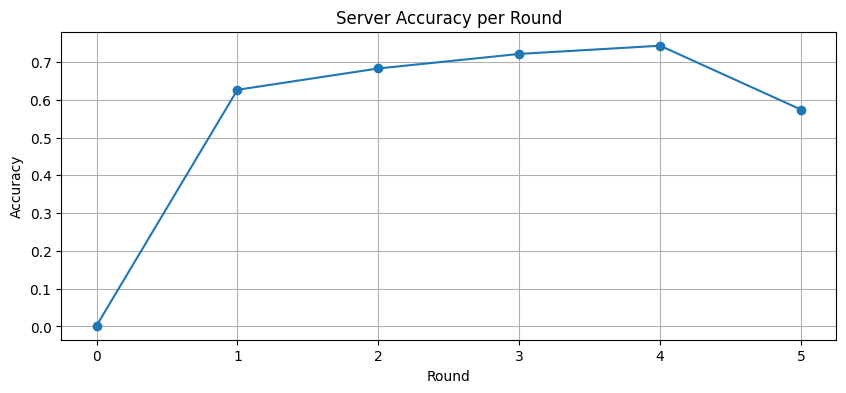

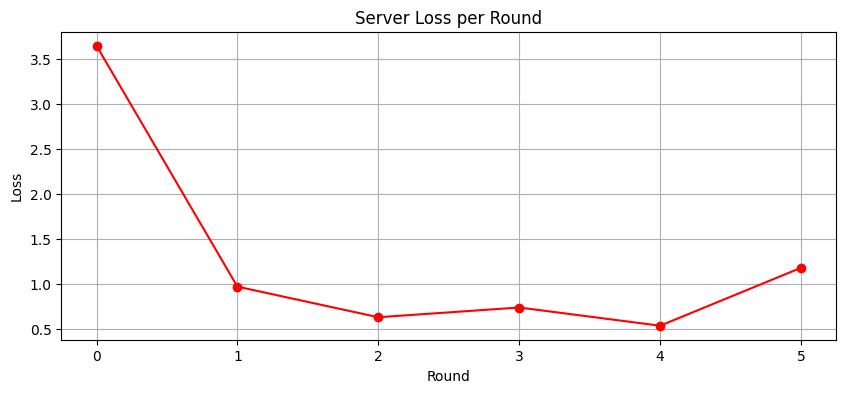

In [42]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
